## 1. Setup and Data Loading

In [1]:
# Imports, plotting setup, and load the bank dataset for Q1 (keep duration dropped later if needed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load dataset
data_path = Path('Data/bank-additional-full.csv')
df = pd.read_csv(data_path, sep=';')

print(f"Dataset loaded: {len(df):,} records")
print(f"Columns: {list(df.columns)}")
print(f"\nTarget distribution:\n{df['y'].value_counts()}")

Dataset loaded: 41,188 records
Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

Target distribution:
y
no     36548
yes     4640
Name: count, dtype: int64


## 2. Train/Test Split

Using 80/20 random split for model validation.

In [2]:
# Split full dataset into train/test (80/20) for Q1 call-count exploration
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Training set: {len(train_df):,} records ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df):,} records ({len(test_df)/len(df)*100:.1f}%)")
print(f"\nTrain target distribution:\n{train_df['y'].value_counts()}")
print(f"\nTest target distribution:\n{test_df['y'].value_counts()}")

Training set: 32,950 records (80.0%)
Test set: 8,238 records (20.0%)

Train target distribution:
y
no     29245
yes     3705
Name: count, dtype: int64

Test target distribution:
y
no     7303
yes     935
Name: count, dtype: int64


## 3. Exploratory Analysis

### 3.1 Average Calls for Successful Conversions

In [3]:
# Inspect 'yes' responders to understand call-count stats before modeling
yes_clients = df[df['y'] == 'yes'].copy()

avg_calls_yes = yes_clients['campaign'].mean()
median_calls_yes = yes_clients['campaign'].median()

print("="*70)
print("SUCCESSFUL CONVERSION ANALYSIS")
print("="*70)
print(f"\nClients who said 'yes': {len(yes_clients):,}")
print(f"Average calls for 'yes': {avg_calls_yes:.2f}")
print(f"Median calls for 'yes': {median_calls_yes:.0f}")
print(f"Min calls: {yes_clients['campaign'].min()}")
print(f"Max calls: {yes_clients['campaign'].max()}")

SUCCESSFUL CONVERSION ANALYSIS

Clients who said 'yes': 4,640
Average calls for 'yes': 2.05
Median calls for 'yes': 2
Min calls: 1
Max calls: 23


### 3.2 Conversion Rate by Number of Calls

In [4]:
# Compute conversion rate grouped by number of campaign calls
conversion_by_calls = df.groupby('campaign').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()]
}).reset_index()
conversion_by_calls.columns = ['calls', 'total', 'yes_count', 'conversion_rate']

# Filter for sufficient sample size (at least 10 clients)
conversion_filtered = conversion_by_calls[conversion_by_calls['total'] >= 10].copy()

# Find peak conversion
peak_idx = conversion_filtered['conversion_rate'].idxmax()
peak_calls = int(conversion_filtered.loc[peak_idx, 'calls'])
peak_rate = conversion_filtered.loc[peak_idx, 'conversion_rate']

print("="*70)
print("PEAK CONVERSION ANALYSIS")
print("="*70)
print(f"\nPeak conversion rate: {peak_rate*100:.2f}%")
print(f"Optimal number of calls: {peak_calls}")

# Find where conversion rate drops significantly (below 50% of peak)
threshold_rate = peak_rate * 0.5
negative_trend = conversion_filtered[
    (conversion_filtered['calls'] > peak_calls) &
    (conversion_filtered['conversion_rate'] < threshold_rate)
]

if len(negative_trend) > 0:
    first_negative = negative_trend.iloc[0]
    print(f"\nConversion rate drops below 50% of peak at {int(first_negative['calls'])} calls")
    print(f"  Rate: {first_negative['conversion_rate']:.4f} ({first_negative['conversion_rate']*100:.2f}%)")

# Find where conversion rate becomes very low (< 1%)
very_low = conversion_filtered[conversion_filtered['conversion_rate'] < 0.01]
if len(very_low) > 0:
    print(f"\n⚠ Recommendation: Stop calling after {int(very_low.iloc[0]['calls'])} calls")
    print(f"  (Conversion rate drops below 1% at this point)")

# Display top conversion rates
print("\nTop 10 conversion rates by call count:")
print(conversion_filtered.nlargest(10, 'conversion_rate')[['calls', 'total', 'yes_count', 'conversion_rate']].to_string(index=False))

PEAK CONVERSION ANALYSIS

Peak conversion rate: 13.04%
Optimal number of calls: 1

Conversion rate drops below 50% of peak at 7 calls
  Rate: 0.0604 (6.04%)

⚠ Recommendation: Stop calling after 16 calls
  (Conversion rate drops below 1% at this point)

Top 10 conversion rates by call count:
 calls  total  yes_count  conversion_rate
     1  17642       2300         0.130371
     2  10570       1211         0.114570
     3   5341        574         0.107471
     4   2651        249         0.093927
     6    979         75         0.076609
     5   1599        120         0.075047
    17     58          4         0.068966
    11    177         12         0.067797
    23     16          1         0.062500
     7    629         38         0.060413


## 4. Logistic Regression Model

Training a logistic regression model to predict subscription likelihood based on call count.

In [5]:
# Build features/target for call-count logistic regression baseline
target_map = {'yes': 1, 'no': 0}
X_train = train_df[['campaign']]
y_train = train_df['y'].map(target_map)
X_test = test_df[['campaign']]
y_test = test_df['y'].map(target_map)

print("="*70)
print("CLASS DISTRIBUTION")
print("="*70)
print(f"Training set - Class 0 (no): {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"Training set - Class 1 (yes): {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"Test set - Class 0 (no): {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"Test set - Class 1 (yes): {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

# Train logistic regression with class balancing
# Using 'balanced' mode adjusts weights inversely proportional to class frequencies
log_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)

# Predictions
y_pred = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Evaluate
train_acc = log_model.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, zero_division=0)
test_recall = recall_score(y_test, y_pred, zero_division=0)
test_f1 = f1_score(y_test, y_pred, zero_division=0)
test_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*70)
print("LOGISTIC REGRESSION MODEL PERFORMANCE")
print("="*70)
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print("\nPrediction Distribution:")
print(f"Predicted 'no' (0): {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")
print(f"Predicted 'yes' (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['no', 'yes'], zero_division=0))

CLASS DISTRIBUTION
Training set - Class 0 (no): 29,245 (88.8%)
Training set - Class 1 (yes): 3,705 (11.2%)
Test set - Class 0 (no): 7,303 (88.7%)
Test set - Class 1 (yes): 935 (11.3%)

LOGISTIC REGRESSION MODEL PERFORMANCE
Training Accuracy: 0.3740 (37.40%)
Test Accuracy: 0.3684 (36.84%)
Test Precision: 0.1248
Test Recall: 0.7594
Test F1-Score: 0.2144
Test AUC-ROC: 0.5487

Prediction Distribution:
Predicted 'no' (0): 2,550 (31.0%)
Predicted 'yes' (1): 5,688 (69.0%)

Classification Report:
              precision    recall  f1-score   support

          no       0.91      0.32      0.47      7303
         yes       0.12      0.76      0.21       935

    accuracy                           0.37      8238
   macro avg       0.52      0.54      0.34      8238
weighted avg       0.82      0.37      0.44      8238



## 5. Polynomial Regression for Trend Analysis

In [6]:
# Aggregate call counts and fit a simple polynomial regression baseline
agg_data = df.groupby('campaign')['y'].apply(lambda x: (x == 'yes').mean()).reset_index()
agg_data.columns = ['campaign', 'conversion_rate']
agg_data = agg_data[agg_data['campaign'] <= 20]  # Limit to first 20 calls

X_agg = agg_data[['campaign']]
y_agg = agg_data['conversion_rate']

# Polynomial transformation (degree 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_agg)

# Fit linear regression on polynomial features
poly_model = LinearRegression()
poly_model.fit(X_poly, y_agg)
y_poly_pred = poly_model.predict(X_poly)

print("Polynomial regression model trained (degree 3)")
print(f"Model R² score: {poly_model.score(X_poly, y_agg):.4f}")

Polynomial regression model trained (degree 3)
Model R² score: 0.8325


## 6. Classification by Peak Threshold

In [7]:
# Flag rows as before/after peak call effectiveness for classification
df['before_peak'] = (df['campaign'] <= peak_calls).astype(int)
df['peak_category'] = df['before_peak'].map({1: 'Before Peak', 0: 'After Peak'})

# Calculate conversion rates by category
category_analysis = df.groupby('peak_category').agg({
    'y': ['count', lambda x: (x == 'yes').sum(), lambda x: (x == 'yes').mean()]
}).reset_index()
category_analysis.columns = ['category', 'total', 'yes_count', 'conversion_rate']

before_rate = category_analysis[category_analysis['category'] == 'Before Peak']['conversion_rate'].values[0]
after_rate = category_analysis[category_analysis['category'] == 'After Peak']['conversion_rate'].values[0]
rate_diff = before_rate - after_rate

print("="*70)
print("BEFORE/AFTER PEAK ANALYSIS")
print("="*70)
print(f"\nBefore Peak (≤{peak_calls} calls): {before_rate*100:.2f}% conversion")
print(f"After Peak (>{peak_calls} calls): {after_rate*100:.2f}% conversion")
print(f"\nDifference: {rate_diff*100:.2f} percentage points")
if rate_diff > 0:
    print(f"Before Peak clients are {(rate_diff/before_rate)*100:.1f}% more likely to subscribe")

print("\nDetailed breakdown:")
print(category_analysis.to_string(index=False))

BEFORE/AFTER PEAK ANALYSIS

Before Peak (≤1 calls): 13.04% conversion
After Peak (>1 calls): 9.94% conversion

Difference: 3.10 percentage points
Before Peak clients are 23.8% more likely to subscribe

Detailed breakdown:
   category  total  yes_count  conversion_rate
 After Peak  23546       2340         0.099380
Before Peak  17642       2300         0.130371


## 7. Visualizations

c:\Users\rythe\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


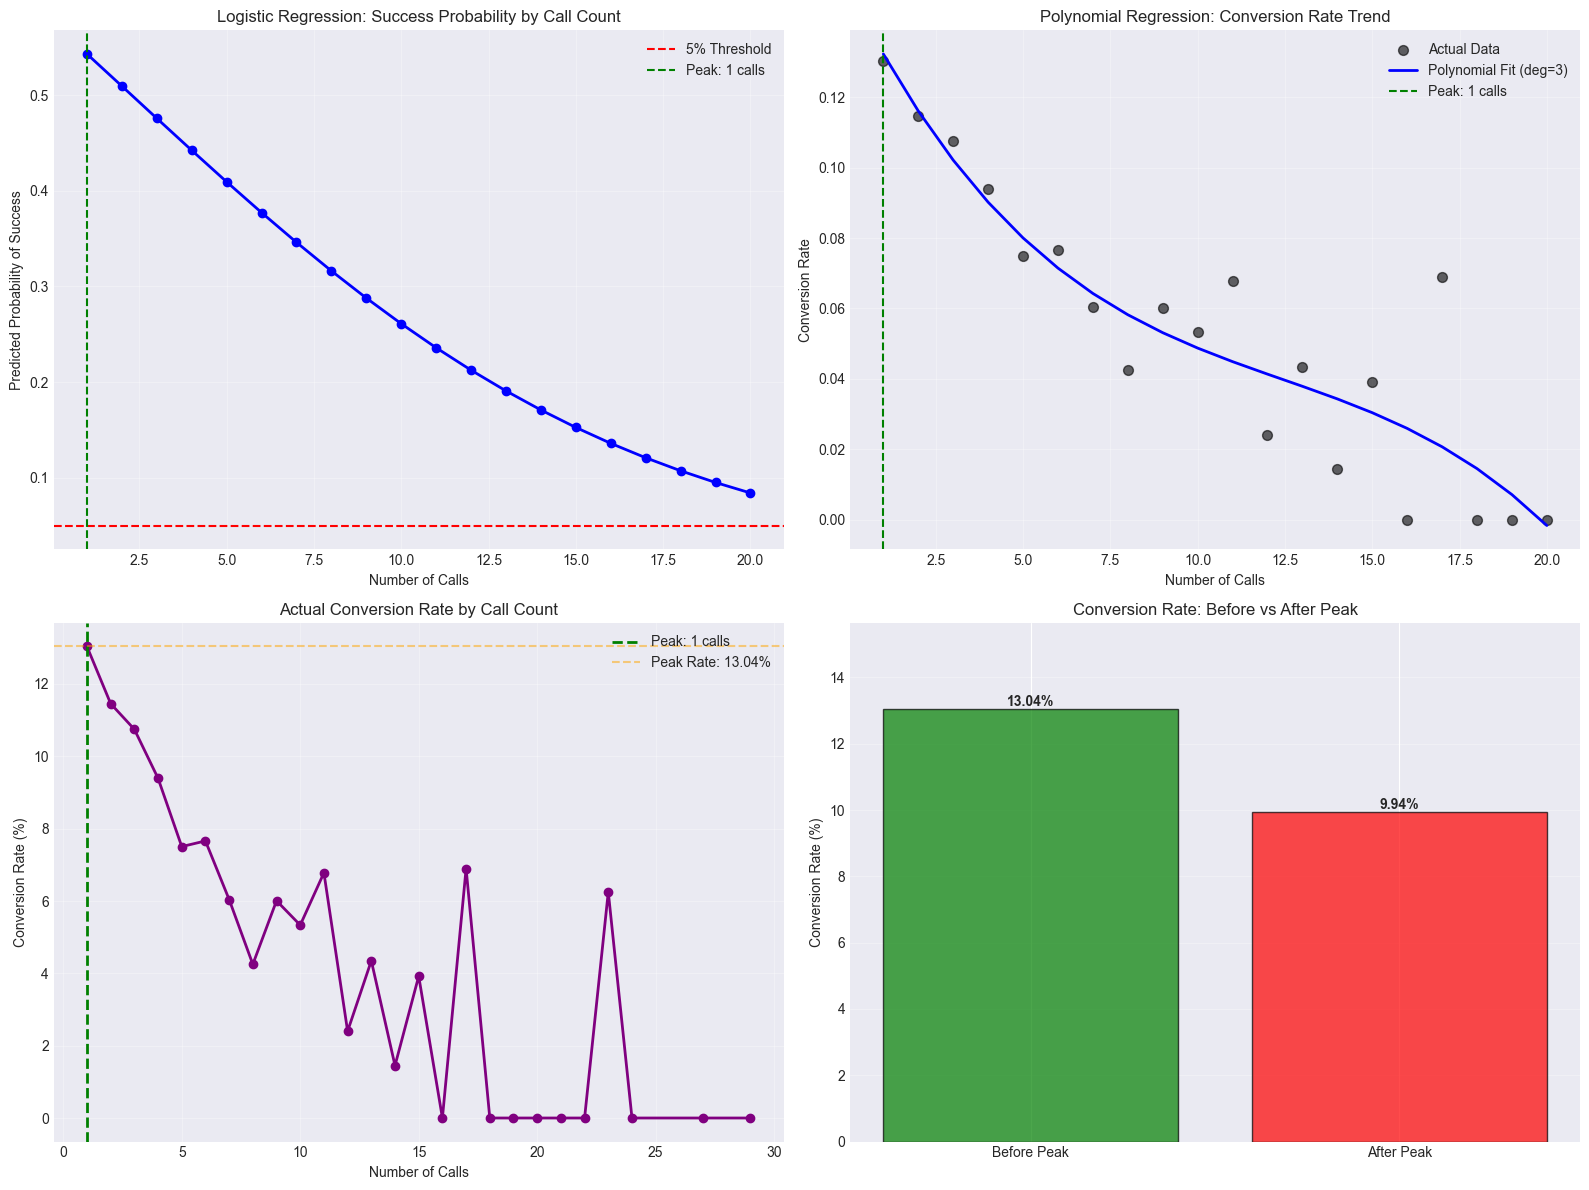

In [8]:
# Fit logistic regression (scaled, balanced) and report metrics on test set
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Logistic regression predicted probability
ax1 = axes[0, 0]
calls_range = np.arange(1, 21).reshape(-1, 1)
probs_range = log_model.predict_proba(calls_range)[:, 1]
ax1.plot(calls_range, probs_range, marker='o', linewidth=2, color='blue')
ax1.axhline(y=0.05, color='r', linestyle='--', label='5% Threshold')
ax1.axvline(x=peak_calls, color='green', linestyle='--', label=f'Peak: {peak_calls} calls')
ax1.set_xlabel('Number of Calls')
ax1.set_ylabel('Predicted Probability of Success')
ax1.set_title('Logistic Regression: Success Probability by Call Count')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Polynomial regression trend
ax2 = axes[0, 1]
ax2.scatter(X_agg, y_agg, color='black', s=50, label='Actual Data', alpha=0.6)
ax2.plot(X_agg, y_poly_pred, color='blue', linewidth=2, label='Polynomial Fit (deg=3)')
ax2.axvline(x=peak_calls, color='green', linestyle='--', label=f'Peak: {peak_calls} calls')
ax2.set_xlabel('Number of Calls')
ax2.set_ylabel('Conversion Rate')
ax2.set_title('Polynomial Regression: Conversion Rate Trend')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Conversion rate by call count
ax3 = axes[1, 0]
ax3.plot(conversion_filtered['calls'], conversion_filtered['conversion_rate']*100,
         marker='o', linewidth=2, color='purple')
ax3.axvline(x=peak_calls, color='green', linestyle='--', linewidth=2,
           label=f'Peak: {peak_calls} calls')
ax3.axhline(y=peak_rate*100, color='orange', linestyle='--', alpha=0.5,
           label=f'Peak Rate: {peak_rate*100:.2f}%')
ax3.set_xlabel('Number of Calls')
ax3.set_ylabel('Conversion Rate (%)')
ax3.set_title('Actual Conversion Rate by Call Count')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Before vs After Peak comparison
ax4 = axes[1, 1]
categories = ['Before Peak', 'After Peak']
rates = [before_rate*100, after_rate*100]
colors = ['green', 'red']
bars = ax4.bar(categories, rates, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Conversion Rate (%)')
ax4.set_title('Conversion Rate: Before vs After Peak')
ax4.set_ylim(0, max(rates)*1.2)
ax4.grid(True, alpha=0.3, axis='y')

for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Prediction Examples

Testing predictions for specific call counts.

In [9]:
# Sanity-check predicted probabilities at specific call counts
test_calls = [1, 3, 5, 10]

print("="*70)
print("PREDICTION EXAMPLES")
print("="*70)

conversion_dict = dict(zip(conversion_by_calls['calls'], conversion_by_calls['conversion_rate']))

for call_num in test_calls:
    pred_prob = log_model.predict_proba([[call_num]])[0, 1]
    actual_rate = conversion_dict.get(call_num, 0.0)
    category = 'Before Peak' if call_num <= peak_calls else 'After Peak'
    
    reduction = 0 if peak_rate == 0 else ((peak_rate - actual_rate) / peak_rate) * 100
    
    print(f"\nCall Count: {call_num}")
    print(f"  Category: {category}")
    print(f"  Predicted Probability: {pred_prob:.4f} ({pred_prob*100:.2f}%)")
    print(f"  Actual Conversion Rate: {actual_rate:.4f} ({actual_rate*100:.2f}%)")
    print(f"  Reduction from Peak: {reduction:.1f}%")
    
    # Recommendation logic with lower tolerance thresholds
    if call_num == peak_calls:
        rec = "Optimal - This is the peak conversion rate. Continue calling."
    elif call_num < peak_calls:
        if reduction <= 5:
            rec = "The success rate is close to optimal. Continue calling."
        elif reduction <= 15:
            rec = "The success rate remains high. Continue calling."
        else:
            rec = "Continue calling - building toward peak."
    else:  # call_num > peak_calls
        if reduction <= 5:
            rec = "The success rate is close to optimal. Continue calling."
        elif reduction <= 15:
            rec = "The success rate remains high. Continue calling."
        elif reduction <= 29:
            rec = "Calling is still doable but not recommended."
        elif reduction <= 36:
            rec = "Calling is less effective. Consider stopping soon."
        else:
            rec = "Calling is significantly less effective. Stop calling."
    
    print(f"  Recommendation: {rec}")

PREDICTION EXAMPLES

Call Count: 1
  Category: Before Peak
  Predicted Probability: 0.5430 (54.30%)
  Actual Conversion Rate: 0.1304 (13.04%)
  Reduction from Peak: 0.0%
  Recommendation: Optimal - This is the peak conversion rate. Continue calling.

Call Count: 3
  Category: After Peak
  Predicted Probability: 0.4757 (47.57%)
  Actual Conversion Rate: 0.1075 (10.75%)
  Reduction from Peak: 17.6%
  Recommendation: Calling is still doable but not recommended.

Call Count: 5
  Category: After Peak
  Predicted Probability: 0.4093 (40.93%)
  Actual Conversion Rate: 0.0750 (7.50%)
  Reduction from Peak: 42.4%
  Recommendation: Calling is significantly less effective. Stop calling.

Call Count: 10
  Category: After Peak
  Predicted Probability: 0.2610 (26.10%)
  Actual Conversion Rate: 0.0533 (5.33%)
  Reduction from Peak: 59.1%
  Recommendation: Calling is significantly less effective. Stop calling.


c:\Users\rythe\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\rythe\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\rythe\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\rythe\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## 9. Summary and Recommendations

In [10]:
# Plot/auxiliary step for visualizing call-response curve (supporting analysis)
print("="*70)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*70)

print(f"\n1. OPTIMAL CALL COUNT")
print(f"   Peak conversion occurs at: {peak_calls} calls")
print(f"   Peak conversion rate: {peak_rate*100:.2f}%")

print(f"\n2. AVERAGE FOR SUCCESSFUL CONVERSIONS")
print(f"   Average calls for 'yes' clients: {avg_calls_yes:.2f}")
print(f"   Median calls for 'yes' clients: {median_calls_yes:.0f}")

print(f"\n3. CONVERSION RATE THRESHOLDS")
# Recalculate thresholds for summary
threshold_rate = peak_rate * 0.5
negative_trend = conversion_filtered[
    (conversion_filtered['calls'] > peak_calls) &
    (conversion_filtered['conversion_rate'] < threshold_rate)
]
if len(negative_trend) > 0:
    print(f"   50% of peak threshold crossed at: {int(negative_trend.iloc[0]['calls'])} calls")
    print(f"   Rate at threshold: {negative_trend.iloc[0]['conversion_rate']*100:.2f}%")

very_low = conversion_filtered[conversion_filtered['conversion_rate'] < 0.01]
if len(very_low) > 0:
    print(f"   1% minimum threshold crossed at: {int(very_low.iloc[0]['calls'])} calls")
    print(f"   ⚠ STOP calling after this point!")

print(f"\n4. BEFORE VS AFTER PEAK")
print(f"   Before Peak (≤{peak_calls}): {before_rate*100:.2f}% conversion")
print(f"   After Peak (>{peak_calls}): {after_rate*100:.2f}% conversion")
print(f"   Difference: {rate_diff*100:.2f} percentage points")

print(f"\n5. MODEL PERFORMANCE")
print(f"   Test Accuracy: {test_acc*100:.2f}%")
print(f"   Test AUC-ROC: {test_auc:.4f}")

print(f"\n6. KEY RECOMMENDATIONS")
print(f"   • Focus calling efforts on clients with ≤{peak_calls} calls (OPTIMAL)")
print(f"   • Continue calling if reduction from peak is ≤15%")
print(f"   • Stop calling if reduction from peak is >36%")
if len(very_low) > 0:
    print(f"   • HARD STOP: Do not call beyond {int(very_low.iloc[0]['calls'])} calls (conversion <1%)")
print(f"   • Clients before peak are {(rate_diff/before_rate)*100:.1f}% more likely to subscribe")
print(f"   • Monitor conversion rates and adjust strategy based on actual performance")

print("\n" + "="*70)

FINAL SUMMARY AND RECOMMENDATIONS

1. OPTIMAL CALL COUNT
   Peak conversion occurs at: 1 calls
   Peak conversion rate: 13.04%

2. AVERAGE FOR SUCCESSFUL CONVERSIONS
   Average calls for 'yes' clients: 2.05
   Median calls for 'yes' clients: 2

3. CONVERSION RATE THRESHOLDS
   50% of peak threshold crossed at: 7 calls
   Rate at threshold: 6.04%
   1% minimum threshold crossed at: 16 calls
   ⚠ STOP calling after this point!

4. BEFORE VS AFTER PEAK
   Before Peak (≤1): 13.04% conversion
   After Peak (>1): 9.94% conversion
   Difference: 3.10 percentage points

5. MODEL PERFORMANCE
   Test Accuracy: 36.84%
   Test AUC-ROC: 0.5487

6. KEY RECOMMENDATIONS
   • Focus calling efforts on clients with ≤1 calls (OPTIMAL)
   • Continue calling if reduction from peak is ≤15%
   • Stop calling if reduction from peak is >36%
   • HARD STOP: Do not call beyond 16 calls (conversion <1%)
   • Clients before peak are 23.8% more likely to subscribe
   • Monitor conversion rates and adjust strategy ba

In [11]:
# Derive recommended call thresholds given target reduction percentages
print("="*70)
print("REDUCTION THRESHOLD ANALYSIS")
print("="*70)
print(f"\nPeak: {peak_calls} calls with {peak_rate*100:.2f}% conversion rate")
print("\nFinding where conversion drops to specific reduction levels:")

# Calculate target rates for different reduction percentages
reductions = [5, 15, 29, 36]
for reduction_pct in reductions:
    target_rate = peak_rate * (1 - reduction_pct/100)
    
    # Find first call count where conversion drops below this target
    below_target = conversion_filtered[
        (conversion_filtered['calls'] > peak_calls) &
        (conversion_filtered['conversion_rate'] < target_rate)
    ]
    
    if len(below_target) > 0:
        first_below = below_target.iloc[0]
        print(f"\n{reduction_pct}% reduction threshold:")
        print(f"  Target rate: {target_rate*100:.2f}%")
        print(f"  First drops below at: {int(first_below['calls'])} calls")
        print(f"  Actual rate at {int(first_below['calls'])} calls: {first_below['conversion_rate']*100:.2f}%")
        print(f"  → Recommendation: Stop calling after {int(first_below['calls'])-1} calls for this threshold")
    else:
        print(f"\n{reduction_pct}% reduction threshold: Never reached in dataset")

print("\n" + "="*70)

REDUCTION THRESHOLD ANALYSIS

Peak: 1 calls with 13.04% conversion rate

Finding where conversion drops to specific reduction levels:

5% reduction threshold:
  Target rate: 12.39%
  First drops below at: 2 calls
  Actual rate at 2 calls: 11.46%
  → Recommendation: Stop calling after 1 calls for this threshold

15% reduction threshold:
  Target rate: 11.08%
  First drops below at: 3 calls
  Actual rate at 3 calls: 10.75%
  → Recommendation: Stop calling after 2 calls for this threshold

29% reduction threshold:
  Target rate: 9.26%
  First drops below at: 5 calls
  Actual rate at 5 calls: 7.50%
  → Recommendation: Stop calling after 4 calls for this threshold

36% reduction threshold:
  Target rate: 8.34%
  First drops below at: 5 calls
  Actual rate at 5 calls: 7.50%
  → Recommendation: Stop calling after 4 calls for this threshold

